## Brain tumor classification using MRI images

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
dataDir = "Data"

labels = []
for dirname, dirnames, filenames in os.walk(os.path.join(dataDir, "Training")):
  if(len(dirnames) > 0):
    labels = dirnames
    break
print(labels)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [3]:
image_size = 150
def load_data(dataDir, labels, train=True):
  data = []
  y = []
  if(train):
    dir = "Training"
  else:
    dir = "Testing"
  for label in labels:
    for dirname, dirnames, filenames in os.walk(os.path.join(dataDir, dir, label)):
      for filename in filenames:
        img = cv2.imread(os.path.join(dirname, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (image_size, image_size))
        data.append(img)
        y.append(labels.index(label))
  return data, np.array(y)


2870
[0 0 0 ... 3 3 3]
394
glioma_tumor


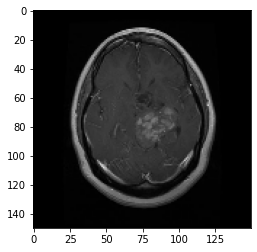

In [5]:
X_train, y_train = load_data(dataDir, labels, train=True)
X_test, y_test = load_data(dataDir, labels, train=False)
print(f"velicina skupa za treniranje {len(X_train)}")
print(y_train)
print(f"velicina skupa za testiranje: {len(X_test)}")
plt.imshow(X_train[0])


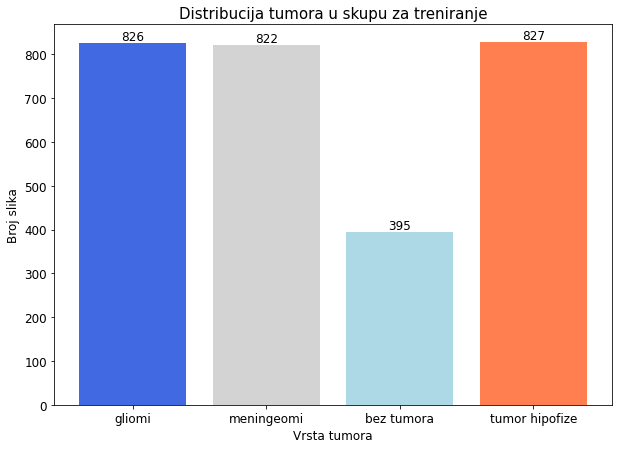

In [45]:

c = Counter(y_train)
frekvencije = [c[i] for i in range(0, len(labels))]
#print(c)
tumor = ["gliomi","meningeomi","bez tumora","tumor hipofize"]
fig, ax = plt.subplots(figsize = (10, 7))
bars = plt.bar(tumor, frekvencije, color = ["royalblue", "lightgray", "lightblue","coral"])
ax.bar_label(bars,size = 12)

for item in ([ ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.xlabel("Vrsta tumora")
plt.ylabel("Broj slika")
plt.title("Distribucija tumora u skupu za treniranje")
ax.title.set_fontsize(15)
plt.show()

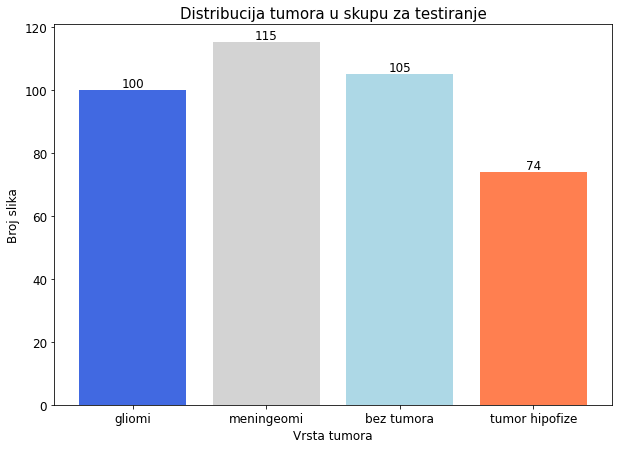

In [46]:
c = Counter(y_test)
frekvencije = [c[i] for i in range(0, len(labels))]
#print(c)
tumor = ["gliomi","meningeomi","bez tumora","tumor hipofize"]
fig, ax = plt.subplots(figsize = (10, 7))
bars = plt.bar(tumor, frekvencije, color = ["royalblue", "lightgray", "lightblue","coral"])
ax.bar_label(bars,size = 12)

for item in ([ ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.xlabel("Vrsta tumora")
plt.ylabel("Broj slika")
plt.title("Distribucija tumora u skupu za testiranje")
ax.title.set_fontsize(15)
plt.show()

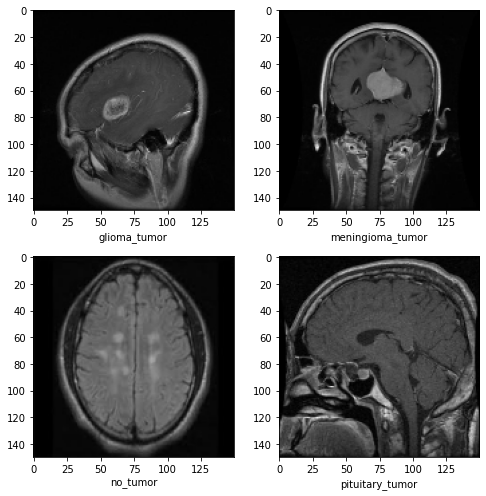

In [31]:
plt.subplots(2, 2, figsize=(7, 7))
for i, k in enumerate([5,950,1820,2407]):
    
    plt.subplot(2, 2, i + 1)
    plt.xlabel(labels[y_train[k]])
    plt.imshow(X_train[k],cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()


In [5]:
X_train, y_train = shuffle(X_train, y_train)
print(y_train)
y_train = tf.keras.utils.to_categorical(y_train)

[3 0 0 ... 3 1 1]
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [32]:
y_test = tf.keras.utils.to_categorical(y_test)
print(y_train)

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [6]:
from tensorflow.keras.applications import EfficientNetV2L
efficient_net = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [7]:
model = efficient_net.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficient_net.input, outputs=model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 75, 75, 32)   864         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 75, 75, 32)   128         ['stem_conv[0][0]']          

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_delta=0.001)

In [10]:
history = model.fit(tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train), epochs=10, batch_size=32, validation_split=0.1, callbacks=[checkpoint, reduce_lr])

Epoch 1/10
81/81 [==============================] - ETA: 0s - loss: 0.5261 - accuracy: 0.8184 
Epoch 1: val_accuracy improved from -inf to 0.76655, saving model to model.h5
81/81 [==============================] - 1385s 17s/step - loss: 0.5261 - accuracy: 0.8184 - val_loss: 0.4694 - val_accuracy: 0.7666 - lr: 0.0010
Epoch 2/10
81/81 [==============================] - ETA: 0s - loss: 0.2377 - accuracy: 0.9202 
Epoch 2: val_accuracy improved from 0.76655 to 0.93380, saving model to model.h5
81/81 [==============================] - 1395s 17s/step - loss: 0.2377 - accuracy: 0.9202 - val_loss: 0.1975 - val_accuracy: 0.9338 - lr: 0.0010
Epoch 3/10
81/81 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.9555 
Epoch 3: val_accuracy improved from 0.93380 to 0.94774, saving model to model.h5
81/81 [==============================] - 1328s 16s/step - loss: 0.1445 - accuracy: 0.9555 - val_loss: 0.1281 - val_accuracy: 0.9477 - lr: 0.0010
Epoch 4/10
81/81 [======================

In [38]:
prediction = model.predict(tf.convert_to_tensor(X_test))

In [39]:
prediction_y = []
for row in prediction:
  index = np.argmax(row)
  prediction_y.append(index)

print(prediction_y)
y_test_numerical = np.argmax(y_test, axis=1)
print(y_test_numerical)

[1, 1, 1, 3, 3, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 0, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 3, 3, 2, 1, 1, 3, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 

In [40]:
print(classification_report(y_test_numerical,prediction_y))

              precision    recall  f1-score   support

           0       1.00      0.19      0.32       100
           1       0.69      0.99      0.81       115
           2       0.71      1.00      0.83       105
           3       0.92      0.77      0.84        74

    accuracy                           0.75       394
   macro avg       0.83      0.74      0.70       394
weighted avg       0.82      0.75      0.70       394



In [41]:
print(confusion_matrix(y_test_numerical,prediction_y))

[[ 19  43  33   5]
 [  0 114   1   0]
 [  0   0 105   0]
 [  0   8   9  57]]
